In [3]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dx: 0.9762202753441801 cm
nx 800


Text(0, 0.5, 'z (m)')

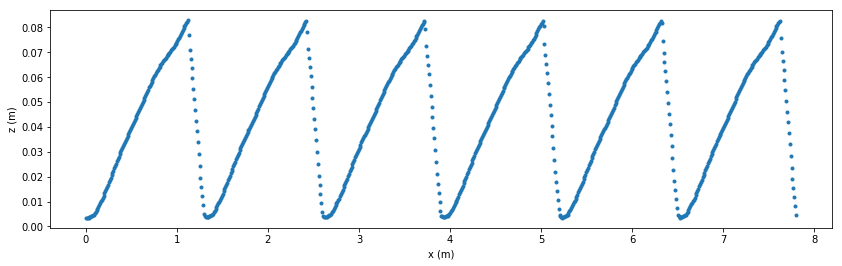

In [4]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 800)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

# Model Runs for Paper

- Equilibrium vs non-Equlibrium
- Shallow water vs simple flow model
- modified Ycr (+20%, -20%)
- other models (Euler, Upwinding, MacCormick)

In [5]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.0012
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 20 cm Case Non-Equilibrium

2019-05-16 01:01:00,071 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:34,981 INFO CLAW: Solution 1 computed for time t=300.000000
0.24260243853423039
0.47608667230806584


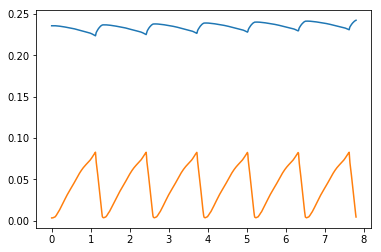

<Figure size 1008x432 with 0 Axes>

In [6]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.009762202753441801
Grid nx = 800
Initializing hydrodynamic model...
2019-05-16 01:01:35,242 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:54,195 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.0012
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 8.011480888307682e-06
2019-05-16 01:01:54,233 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:55,173 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 01:01:55,274 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:56,218 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 01:01:56,255 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:57,198 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 01:01:57,278 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:58,232 INFO CLAW: S

Text(0, 0.5, 'z (m)')

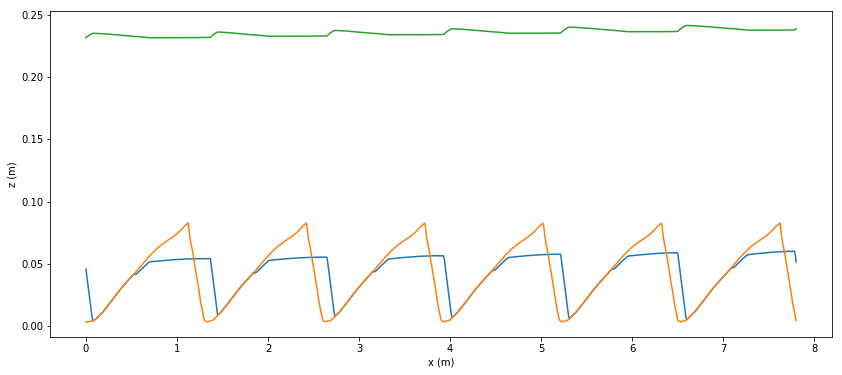

In [7]:


run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('20cm','237mm','1.2mm')

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

## 32 cm Flow Case 

2019-05-16 03:46:48,552 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 03:47:12,781 INFO CLAW: Solution 1 computed for time t=300.000000
0.3632198685789688
0.6292048652669885


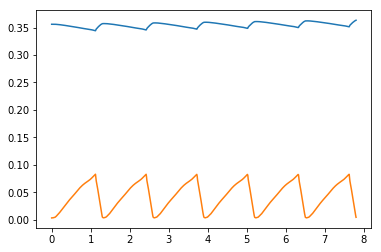

<Figure size 1008x432 with 0 Axes>

In [8]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.009762202753441801
Grid nx = 800
Initializing hydrodynamic model...
2019-05-16 03:47:13,042 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 03:47:47,973 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.0012
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 1.1053488147659778e-05
2019-05-16 03:47:48,041 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 03:47:50,332 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 03:47:50,503 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 03:47:52,788 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 03:47:52,855 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 03:47:55,142 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 03:47:55,248 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 03:47:57,539 INFO CLAW: 

Text(0, 0.5, 'z (m)')

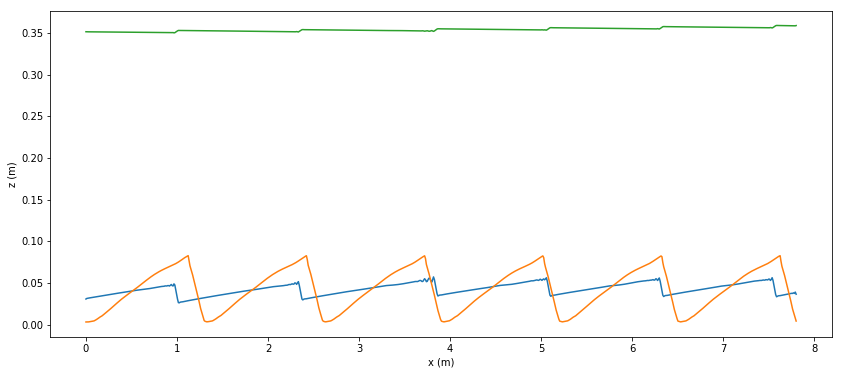

In [9]:
run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1.2mm')

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [10]:
df

,height,length,speed
